# Methods and Parameters for Handling 3D-Data

Tobac is also capable of processing 3-dimensional data, but there are certain aspects that need to be understood. These will be covered in this notebook with the following chapters:

- [Visualization](#Visualization)
- [Feature Detection](#Feature-Detection)
- [Segmentation](#Segmentation)
- [Linking](#Linking)

## Visualization

We start by loading in the usual libraries:

In [1]:
import tobac
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")

%matplotlib inline

An example of 3D-data can be produced by a build-in utility:

In [13]:
data = tobac.testing.make_sample_data_3D_3blobs()
data

<xarray.DataArray 'w' (time: 25, z: 20, y: 200, x: 100)>
[10000000 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-01-01T12:48:00
  * z          (z) float64 0.0 1e+03 2e+03 3e+03 ... 1.7e+04 1.8e+04 1.9e+04
  * y          (y) float64 0.0 1e+03 2e+03 3e+03 ... 1.97e+05 1.98e+05 1.99e+05
  * x          (x) float64 0.0 1e+03 2e+03 3e+03 ... 9.7e+04 9.8e+04 9.9e+04
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
Attributes:
    units:    m s-1

As you can see, this dataset has an additional *z*-coordinate, indicating a height. In general with such datasets visualisation is a bit more complicated. We can have a look at the values at the different heights of the last frame with the built-in plotting routine of `xarray`:

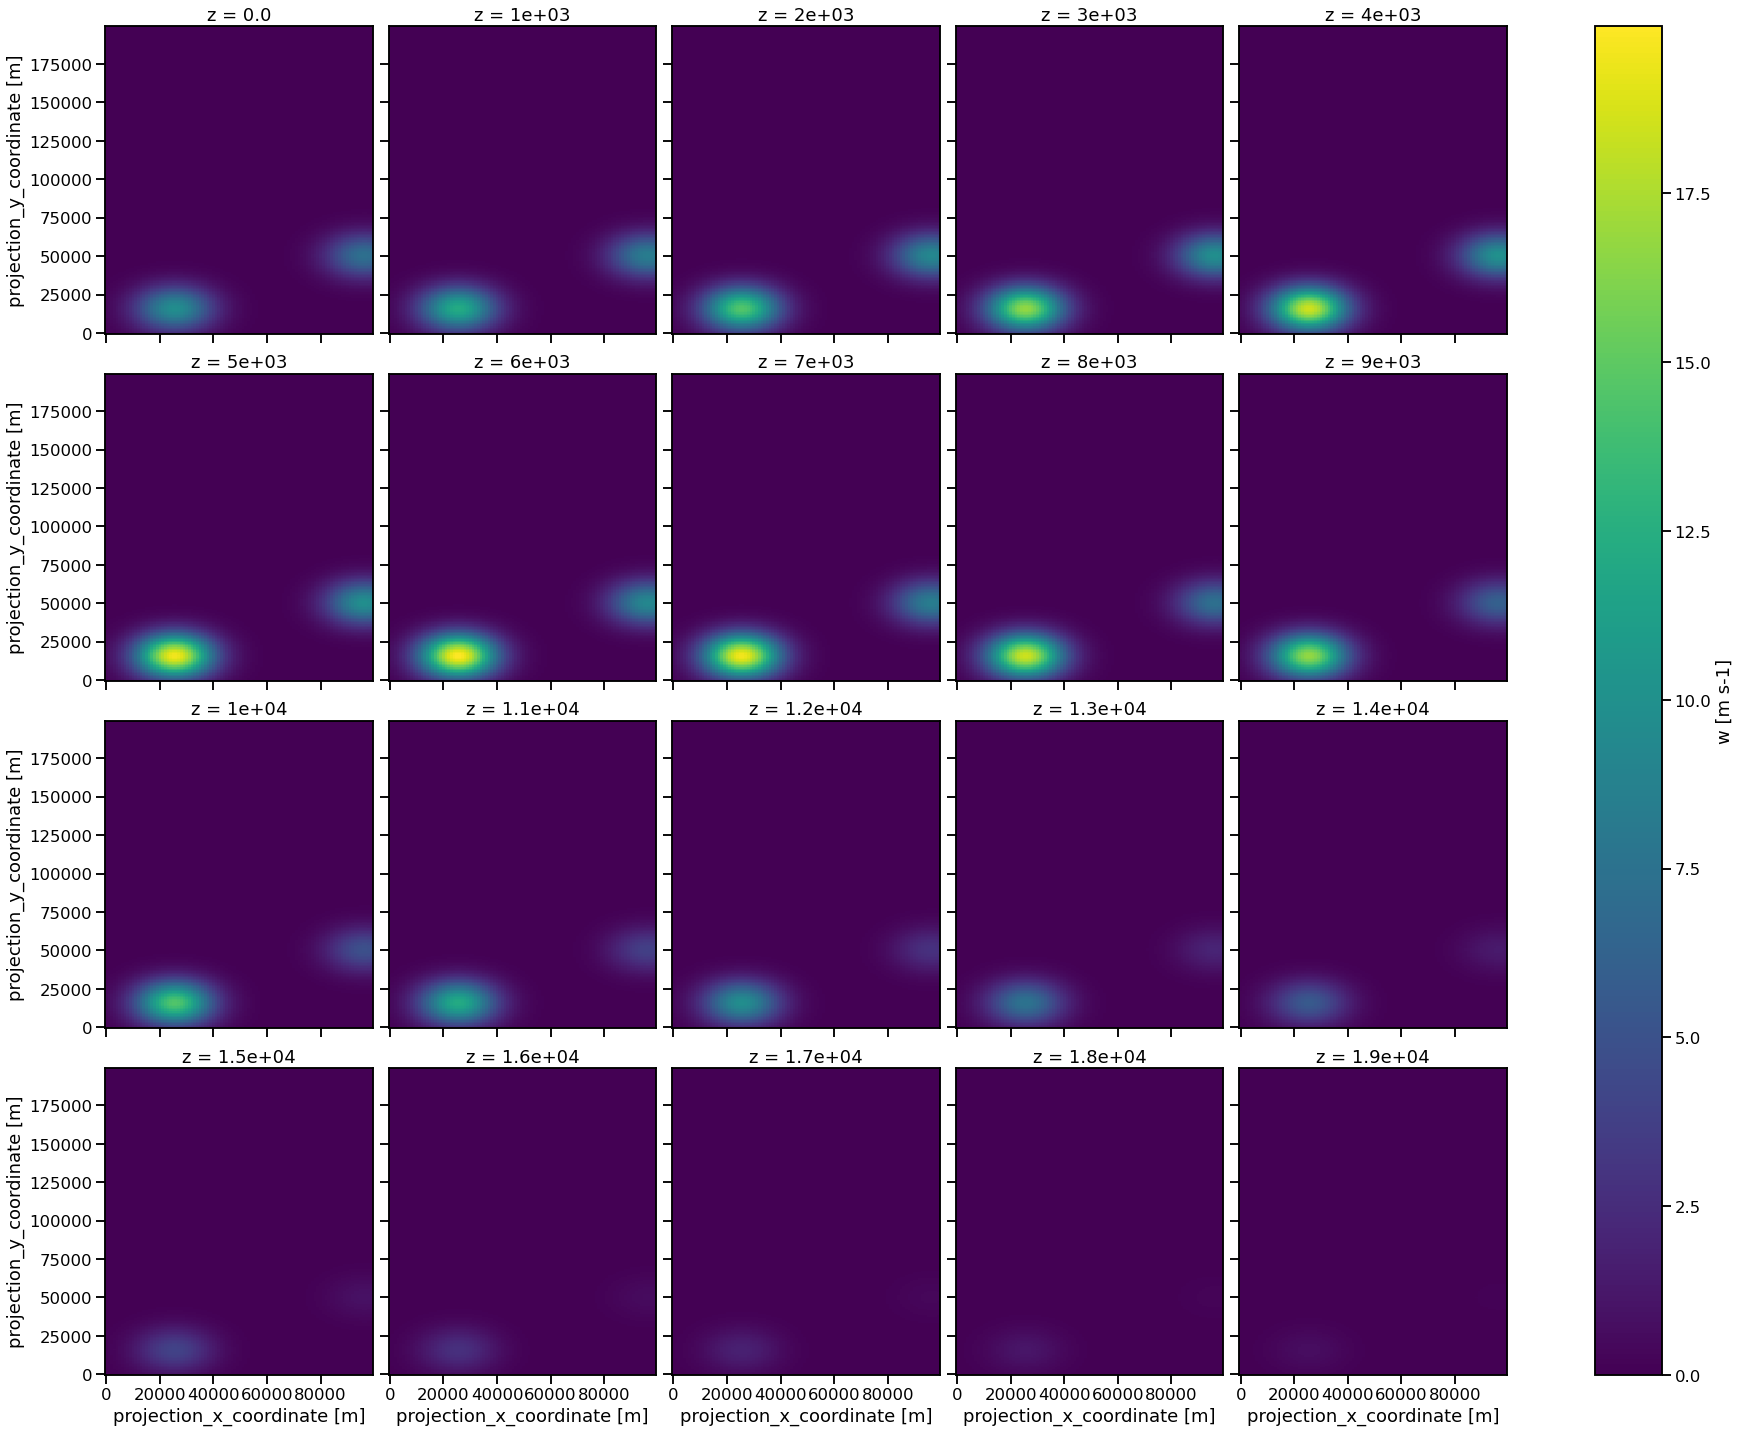

In [27]:
data[-1].plot(cmap="viridis", col="z", col_wrap=5, size=5)

## Feature Detection

As before, the workfllow starts with the feature detetection. Note, however, that only a **two dimensional** input is allowed for the `feature_detection_multithreshold()`-function. In order to find all features we create a subdataset by selecting only the *z*-layers with the highest values from our generated field for each timeframe:

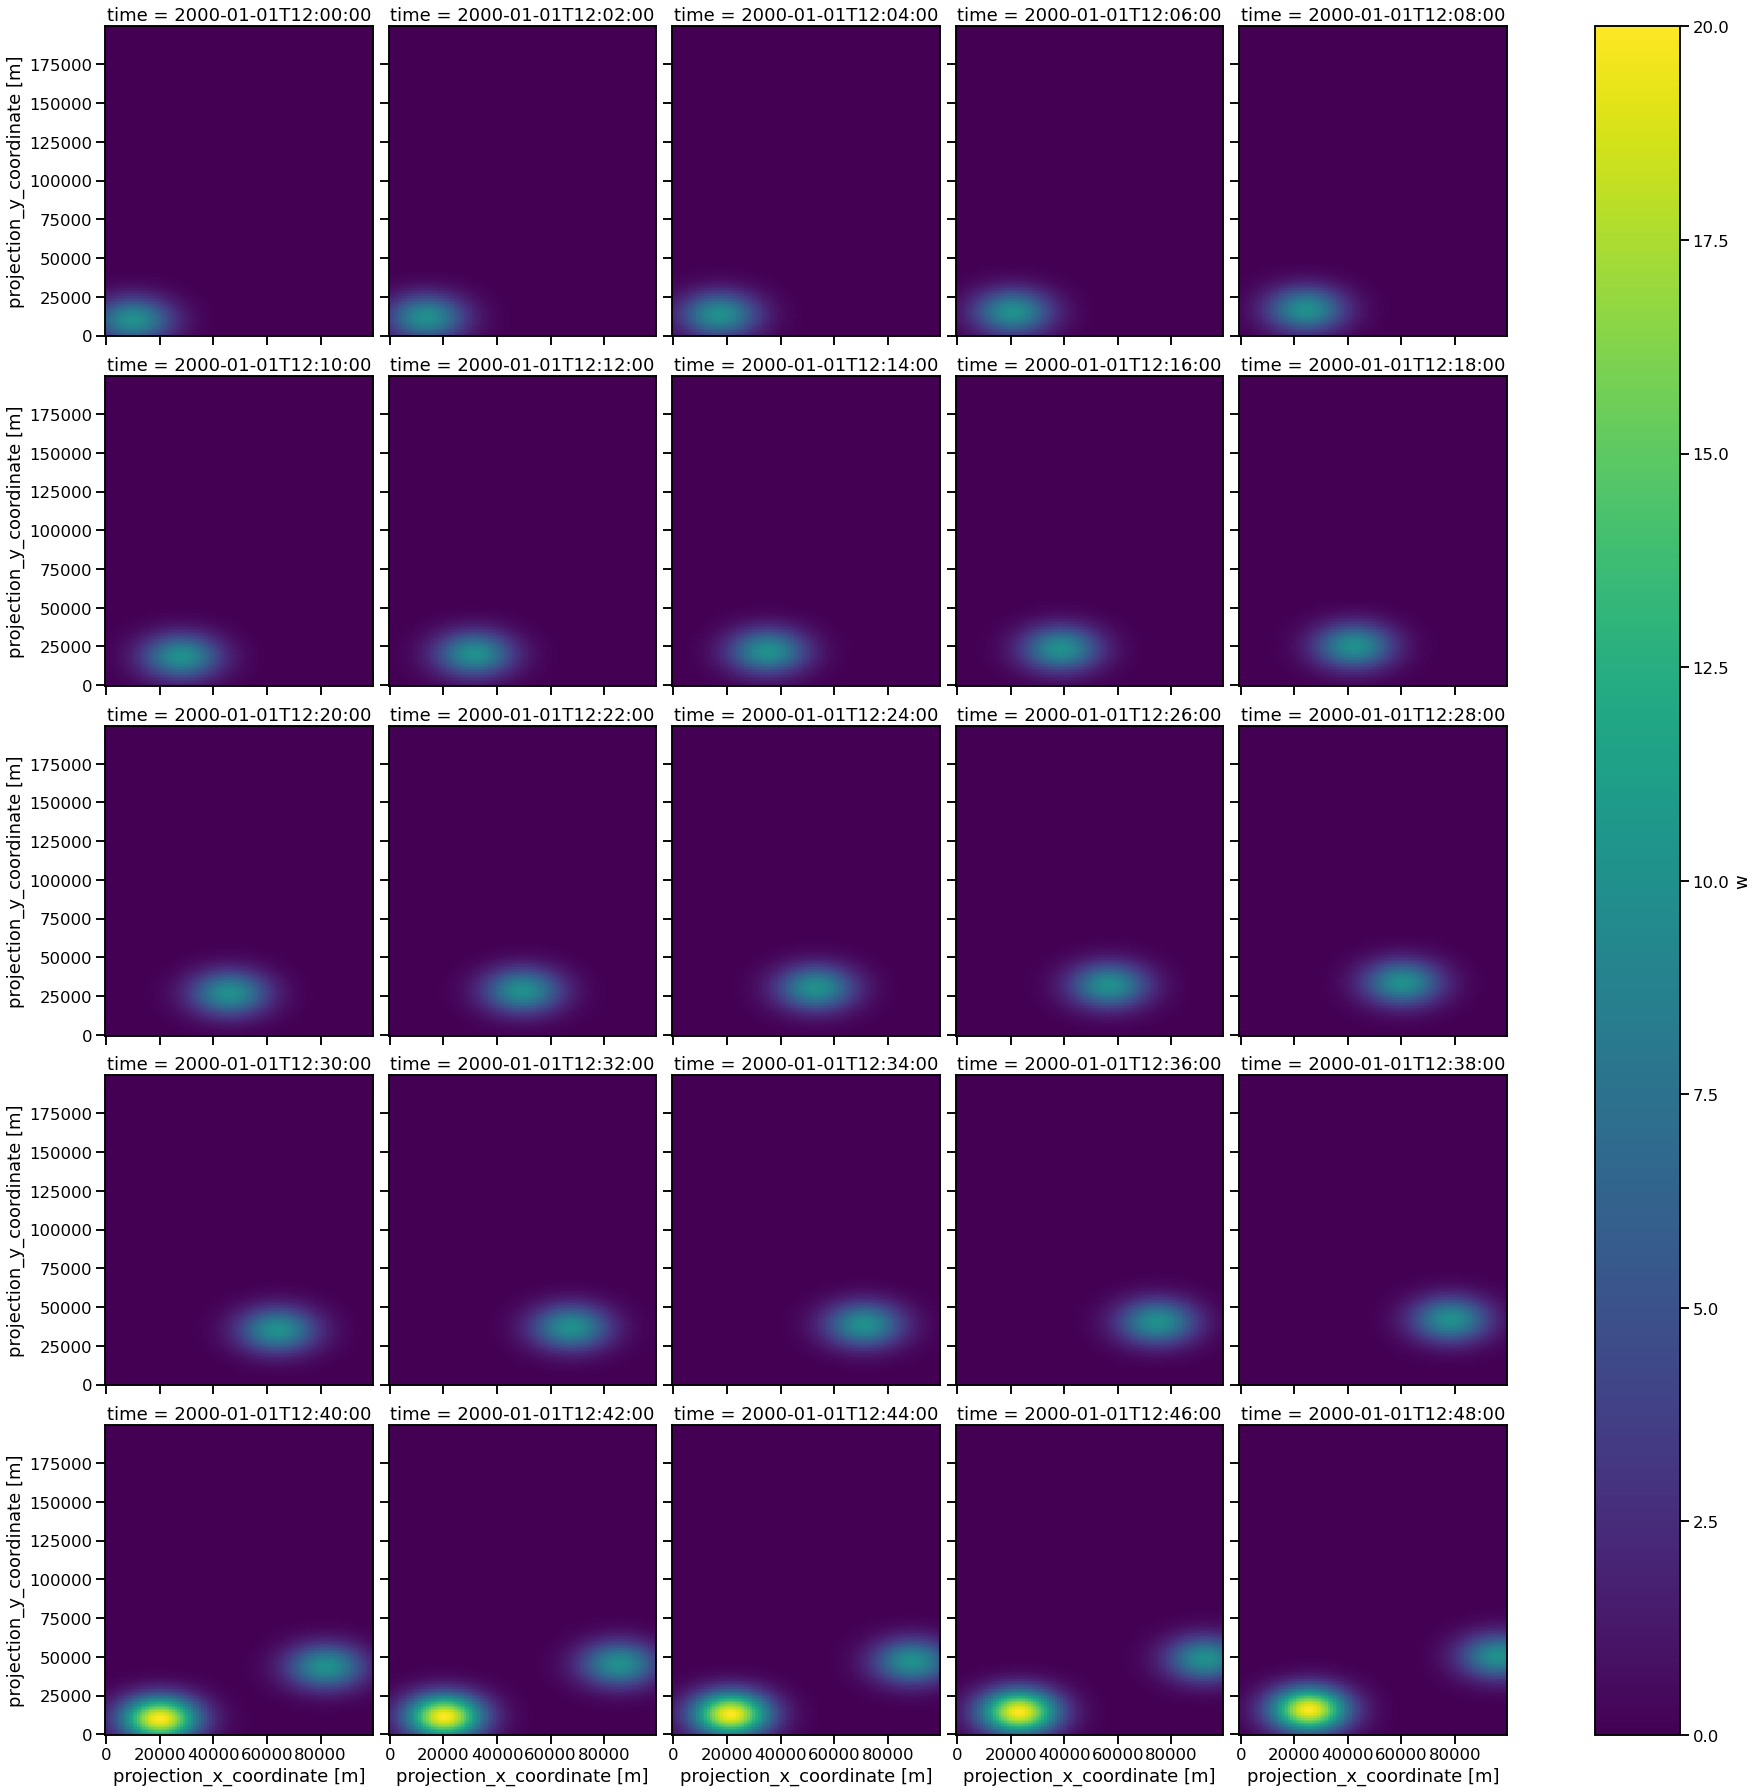

In [45]:
sample_data_max = data.max(dim="z")
sample_data_max.plot(cmap="viridis", col="time", col_wrap=5, size=5)

Now the feature detection can be performed for this subdataset as usual with a reasonable threshold of 5:

In [49]:
%%capture
dxy, dt = tobac.utils.get_spacings(sample_data_max)
threshold = 5
features = tobac.themes.tobac_v1.feature_detection_multithreshold(
    sample_data_max, dxy, threshold=threshold
)

The resulting dataset contains the 2d coordinates of the features in the subdataset:

In [50]:
features

<xarray.Dataset>
Dimensions:                  (index: 30)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 6 ... 24 25 26 27 28 29
Data variables: (12/13)
    frame                    (index) int64 0 1 2 3 4 5 6 ... 22 22 23 23 24 24
    idx                      (index) int64 1 1 1 1 1 1 1 1 1 ... 1 2 1 2 1 2 1 2
    hdim_1                   (index) float64 10.24 11.61 13.33 ... 15.77 50.33
    hdim_2                   (index) float64 10.24 13.58 17.19 ... 25.55 93.02
    num                      (index) int64 419 439 434 431 ... 848 366 875 291
    threshold_value          (index) int64 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5
    ...                       ...
    time                     (index) object 2000-01-01 12:00:00 ... 2000-01-0...
    timestr                  (index) object '2000-01-01 12:00:00' ... '2000-0...
    projection_y_coordinate  (index) float64 1.024e+04 1.161e+04 ... 5.033e+04
    projection_x_coordinate  (index) float64 1.024e+04 1.358e+04 ... 9.302e+04
    latitude                 (index) object 24.1 24.14 24.17 ... 24.26 24.93
    longitude                (index) object 150.1 150.1 150.1 ... 150.2 150.5

## Segmentation

The segmentation is performed on the 3D dataset, but with the features from the 2D feature detection. This means that only the features that are present in the subdataset are used as a starting point for the segmentation algorithm.

In [53]:
%%capture
mask, features_mask = tobac.themes.tobac_v1.segmentation(
    features, data, dxy, threshold=threshold
)

The resulting mask of the segments has 3 dimensions and therefore can be visualized similar to the field itself. At points that belong to a feature the values of the masks are the corresponding feature numbers and 0 everywhere else.

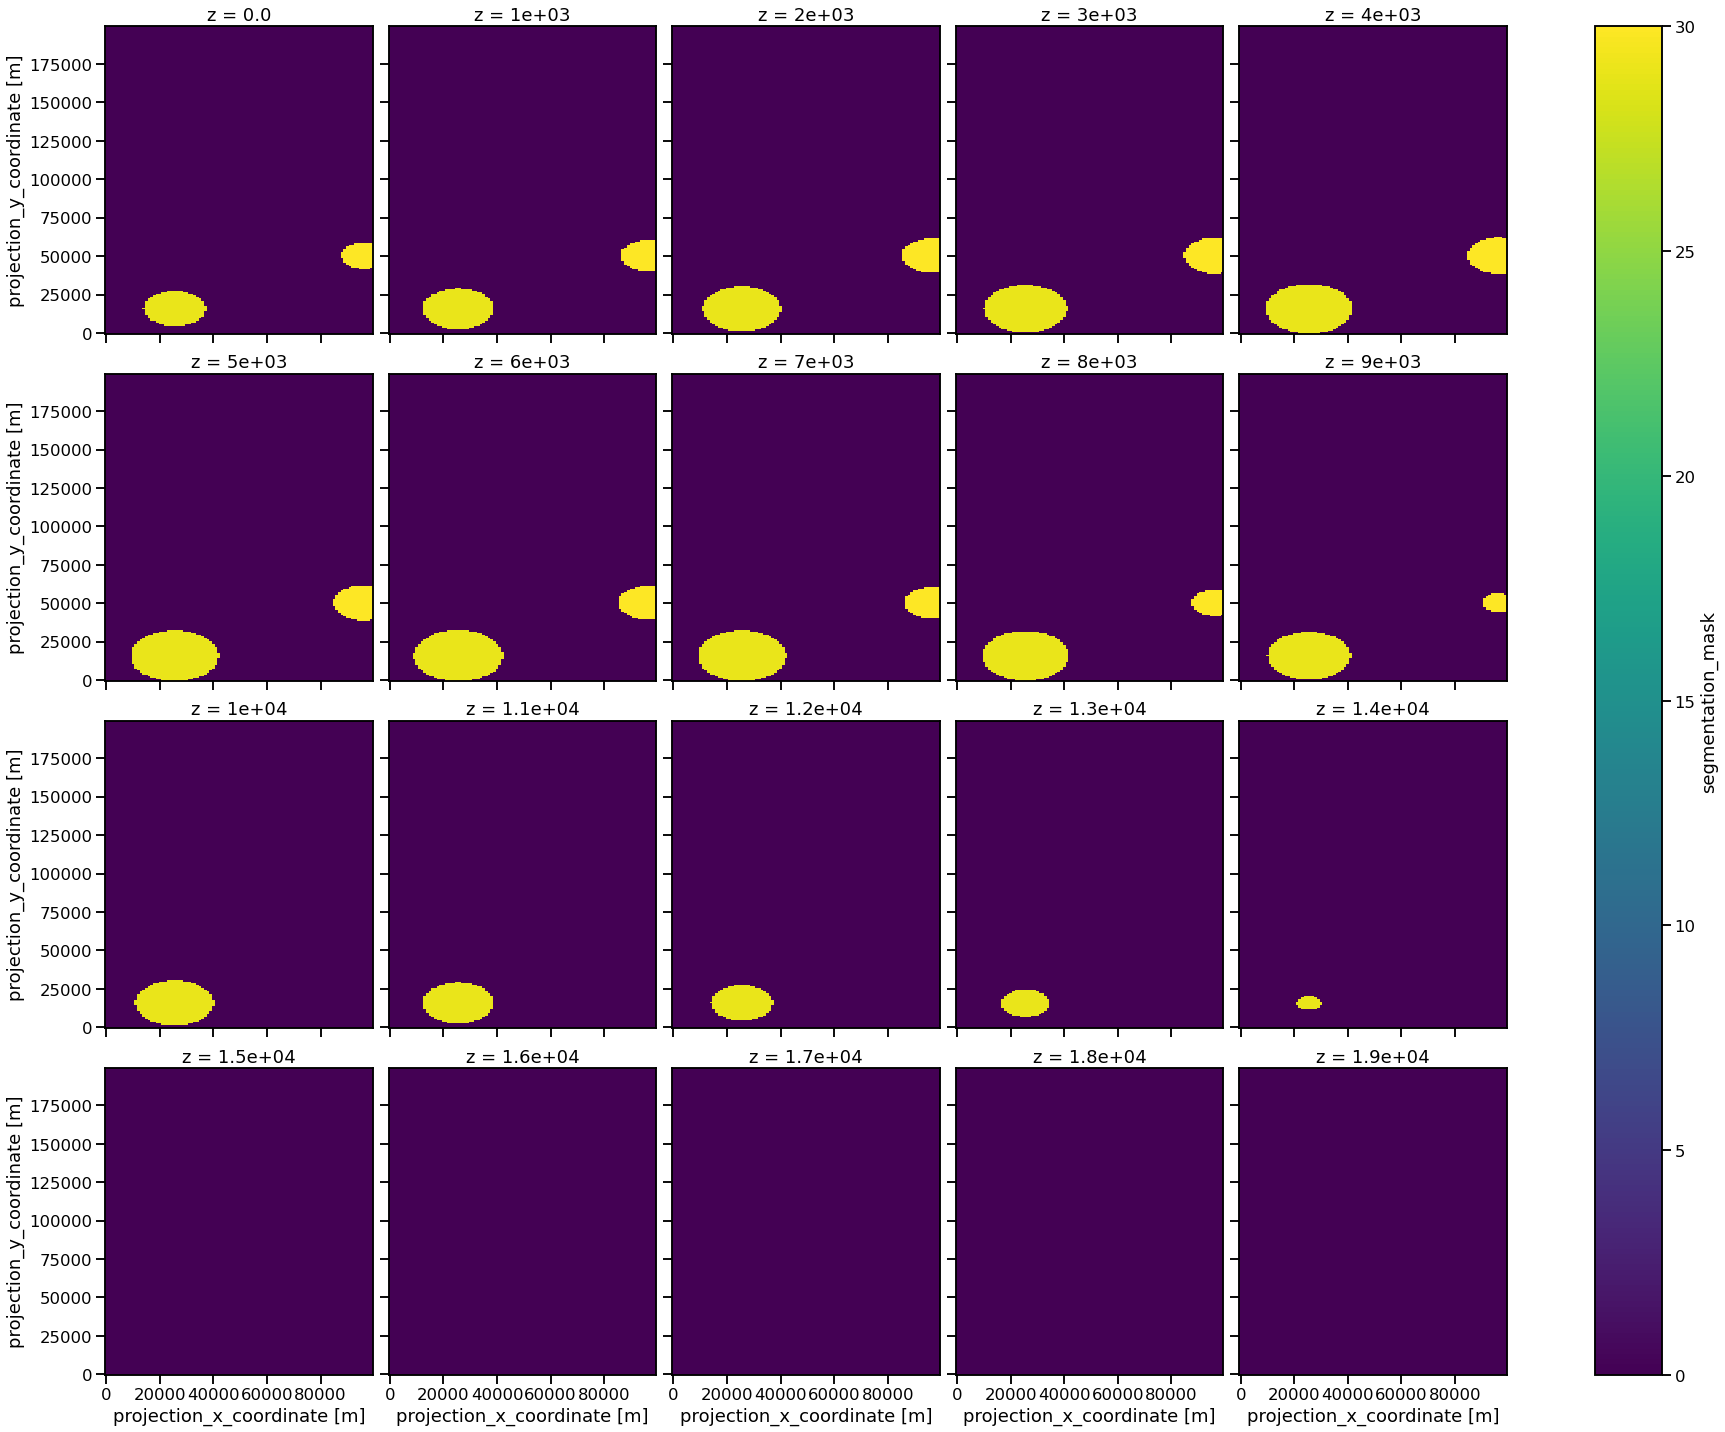

In [144]:
mask[24].plot(cmap="viridis", col="z", col_wrap=5, size=5)

### vertical_coord

Depending on your dataset it is possible to have more than one coordinate that could be used as the third dimension during the segmentation. Which one will be used can be specified with the `vertical_coord` parameter. The possible strings are *z*, *model_level_number*, *altitude*, *geopotential_height* and *auto*, with *auto* as the default. Which of them your dataset contains can be checked by transforming it to the iris format:

In [139]:
data.to_iris()

W (m s-1),time,geopotential_height,projection_y_coordinate,projection_x_coordinate
Shape,25,20,200,100
Dimension coordinates,,,,
time,x,-,-,-
geopotential_height,-,x,-,-
projection_y_coordinate,-,-,x,-
projection_x_coordinate,-,-,-,x
Auxiliary coordinates,,,,
latitude,-,-,x,x
longitude,-,-,x,x


As you can see, *geopotential_height* is the only possible option here and it would be selected automatically with *auto*, but we can also specify it explicitly:

In [148]:
mask, features_mask = tobac.themes.tobac_v1.segmentation(
    features, data, dxy, threshold=threshold, vertical_coord="geopotential_height"
)

<xarray.DataArray 'w' (time: 25, z: 20, y: 200, x: 100)>
[10000000 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-01-01T12:48:00
  * z          (z) float64 0.0 1e+03 2e+03 3e+03 ... 1.7e+04 1.8e+04 1.9e+04
  * y          (y) float64 0.0 1e+03 2e+03 3e+03 ... 1.97e+05 1.98e+05 1.99e+05
  * x          (x) float64 0.0 1e+03 2e+03 3e+03 ... 9.7e+04 9.8e+04 9.9e+04
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
Attributes:
    units:    m s-1


Any other value for that parameter would result in an exception.

## Linking

The linking process works again with the 2 dimensional feature dataset. The field needs to be defined as input, but it does not affect the algorithm. Therefore the resulting tracks are again 2 dimensional and the parameters can be handled completely analogous to the 2D cases.

In [151]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt, dxy, v_max=100)

Frame 24: 2 trajectories present.


In [152]:
track

<xarray.Dataset>
Dimensions:                  (index: 30)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 6 ... 24 25 26 27 28 29
Data variables: (12/15)
    frame                    (index) int64 0 1 2 3 4 5 6 ... 22 22 23 23 24 24
    idx                      (index) int64 1 1 1 1 1 1 1 1 1 ... 1 2 1 2 1 2 1 2
    hdim_1                   (index) float64 10.24 11.61 13.33 ... 15.77 50.33
    hdim_2                   (index) float64 10.24 13.58 17.19 ... 25.55 93.02
    num                      (index) int64 419 439 434 431 ... 848 366 875 291
    threshold_value          (index) int64 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5
    ...                       ...
    projection_y_coordinate  (index) float64 1.024e+04 1.161e+04 ... 5.033e+04
    projection_x_coordinate  (index) float64 1.024e+04 1.358e+04 ... 9.302e+04
    latitude                 (index) object 24.1 24.14 24.17 ... 24.26 24.93
    longitude                (index) object 150.1 150.1 150.1 ... 150.2 150.5
    cell                     (index) float64 1.0 1.0 1.0 1.0 ... 2.0 1.0 2.0 1.0
    time_cell                (index) timedelta64[ns] 00:00:00 ... 00:48:00